In [1]:
import datetime
import math
import os
import pickle
import re
import logging
from collections import Counter, OrderedDict, defaultdict
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import pandas as pd
import torch
import pyro.distributions as dist
from pyro.ops.tensor_utils import convolve
from scipy.interpolate import make_interp_spline
from scipy import interpolate
import seaborn as sns

### Lineage

In [66]:
coefficient_dataset = torch.load('./data/coefficient_dataset_Site_world.pkl')

locations = coefficient_dataset['locations']
lineages = coefficient_dataset['lineages']
mutations = coefficient_dataset['mutations']
country_index = locations.index('Italy')

# beta_PL = coefficient_dataset['rate'][country_index,:].unsqueeze(0)
beta_PL = coefficient_dataset['rate']
alpha_PL = coefficient_dataset['init']
beta_M = coefficient_dataset['coef']


In [67]:
lineage_fitness = beta_PL.sum(0) - beta_PL.sum(0)[lineages.index('B.1.1.529')]

lineage_fitness_value = lineage_fitness.sort(0, True)[0]
lineage_fitness_index = lineage_fitness.sort(0, True)[1].tolist()
lineage_fitness_name = []
for i in lineage_fitness_index:
    lineage_fitness_name.append(lineages[i])

relative_fitness = pow(1e3,lineage_fitness_value)
# lineage_fitness_value / lineage_fitness_value[lineage_fitness_name.index('B.1.1.529')]

In [68]:
dic = {
    'lineage' : lineage_fitness_name,
    'relative fitness' : relative_fitness
}
lineage_fitness = pd.DataFrame(dic)

In [69]:
dataset = torch.load('./data/Omicron_experimental_data_new.pkl')

counts = dataset['counts'].sum(1)
# counts = dataset['counts'][:,country_index,:]
time_step_days = dataset["time_step_days"]
start_date = dataset['start_date']

In [70]:
lineage_fitness['start date'] = ''
lineage_fitness['date index'] = ''
for i in range(len(lineage_fitness)):
    lineage_index = lineages.index(lineage_fitness['lineage'][i])
    for j in range(counts.shape[0]):
        if counts[j, lineage_index] != 0 and counts[j+1, lineage_index] != 0 and counts[j+2, lineage_index] != 0 and counts[j+3, lineage_index] != 0:
            lineage_fitness['start date'][i] = (start_date + datetime.timedelta(days=j*4)).strftime('%Y-%m-%d')
            lineage_fitness['date index'][i] = j
            break
            
for i in range(len(lineage_fitness)):
    if not lineage_fitness['start date'][i]:
        lineage_index = lineages.index(lineage_fitness['lineage'][i])
        for j in range(counts.shape[0]):
            if counts[j, lineage_index] != 0:
                lineage_fitness['start date'][i] = (start_date + datetime.timedelta(days=j*4)).strftime('%Y-%m-%d')
                break

lineage_fitness['count'] = ''
for i in range(len(lineage_fitness)):
    lineage_index = lineages.index(lineage_fitness['lineage'][i])
    lineage_fitness['count'][i] = counts[:, lineage_index].sum().item()

/var/folders/b4/79t4ch4d6r75j7xb9y8qj3vc0000gn/T/ipykernel_11490/867699547.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lineage_fitness['start date'][i] = (start_date + datetime.timedelta(days=j*4)).strftime('%Y-%m-%d')
/var/folders/b4/79t4ch4d6r75j7xb9y8qj3vc0000gn/T/ipykernel_11490/867699547.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lineage_fitness['date index'][i] = j
/var/folders/b4/79t4ch4d6r75j7xb9y8qj3vc0000gn/T/ipykernel_11490/867699547.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.o

In [71]:
lineage_fitness['color'] = ''
for i in range(len(lineage_fitness)):
    if lineage_fitness['lineage'][i].startswith('XB') or lineage_fitness['lineage'][i].startswith('E') or lineage_fitness['lineage'][i].startswith('F') or lineage_fitness['lineage'][i].startswith('G') or lineage_fitness['lineage'][i].startswith('H'):
        lineage_fitness['color'][i] = 'blue'
    else:
        lineage_fitness['color'][i] = 'red'

/var/folders/b4/79t4ch4d6r75j7xb9y8qj3vc0000gn/T/ipykernel_11490/824024708.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lineage_fitness['color'][i] = 'red'
/var/folders/b4/79t4ch4d6r75j7xb9y8qj3vc0000gn/T/ipykernel_11490/824024708.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lineage_fitness['color'][i] = 'blue'


In [72]:
rou = 5000
for i in range(len(lineage_fitness)):
    if lineage_fitness['count'][i] < rou:
        lineage_fitness = lineage_fitness.drop(i, axis=0)

In [73]:
lineage_fitness.reset_index(drop=True, inplace=True)

In [74]:
size = []
color = []
for i in range(len(lineage_fitness)):
    size.append(lineage_fitness['count'][i] * 0.01)
    color.append(lineage_fitness['color'][i])

In [79]:
### extract label lineage
label_lineage = pd.DataFrame(columns = ['lineage', 'relative_fitness', 'start date', 'count'])
for i in range(len(lineage_fitness)):
    if i < 10:
        s = pd.Series([lineage_fitness['lineage'][i], lineage_fitness['relative fitness'][i], lineage_fitness['start date'][i], lineage_fitness['count'][i]], index=label_lineage.columns)
        label_lineage = label_lineage.append(s, ignore_index=True)
    # elif lineage_fitness['count'][i] > 100000 and lineage_fitness['lineage'][i] != 'Unassigned': # world
    elif lineage_fitness['count'][i] > 80000 and lineage_fitness['lineage'][i] != 'Unassigned':
        s = pd.Series([lineage_fitness['lineage'][i], lineage_fitness['relative fitness'][i], lineage_fitness['start date'][i], lineage_fitness['count'][i]], index=label_lineage.columns)
        label_lineage = label_lineage.append(s, ignore_index=True)
    elif lineage_fitness['lineage'][i] == 'XBB.1.5' or lineage_fitness['lineage'][i] == 'XBB.1.16' or lineage_fitness['lineage'][i] == 'EG.5.1':
        s = pd.Series([lineage_fitness['lineage'][i], lineage_fitness['relative fitness'][i], lineage_fitness['start date'][i], lineage_fitness['count'][i]], index=label_lineage.columns)
        label_lineage = label_lineage.append(s, ignore_index=True)

label_lineage_marker = []
size1 = []
for i in range(len(label_lineage)):
    label_lineage_marker.append('$' + label_lineage['lineage'][i] + '$')
    size1.append(label_lineage['count'][i] * 0.001)

/var/folders/b4/79t4ch4d6r75j7xb9y8qj3vc0000gn/T/ipykernel_11490/924044562.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  label_lineage = label_lineage.append(s, ignore_index=True)
/var/folders/b4/79t4ch4d6r75j7xb9y8qj3vc0000gn/T/ipykernel_11490/924044562.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  label_lineage = label_lineage.append(s, ignore_index=True)
/var/folders/b4/79t4ch4d6r75j7xb9y8qj3vc0000gn/T/ipykernel_11490/924044562.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  label_lineage = label_lineage.append(s, ignore_index=True)
/var/folders/b4/79t4ch4d6r75j7xb9y8qj3vc0000gn/T/ipykernel_11490/924044562.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

In [80]:
df_val = pd.DataFrame(columns=['time','fitness','lineage','group'])
for i in range(len(lineage_fitness)):
    if lineage_fitness['color'][i] == 'red' and pd.to_datetime(lineage_fitness['start date'][i]) > pd.to_datetime('2022-03-01') and pd.to_datetime(lineage_fitness['start date'][i]) < pd.to_datetime('2023-02-01') and lineage_fitness['date index'][i] != '':
        df_val.loc[len(df_val)] = [lineage_fitness['date index'][i],lineage_fitness['relative fitness'][i],lineage_fitness['lineage'][i],'non-recom']
for i in range(len(lineage_fitness)):
    if lineage_fitness['color'][i] == 'blue' and lineage_fitness['date index'][i] != '' and pd.to_datetime(lineage_fitness['start date'][i]) > pd.to_datetime('2022-09-01'):
        df_val.loc[len(df_val)] = [lineage_fitness['date index'][i],lineage_fitness['relative fitness'][i],lineage_fitness['lineage'][i],'recom']

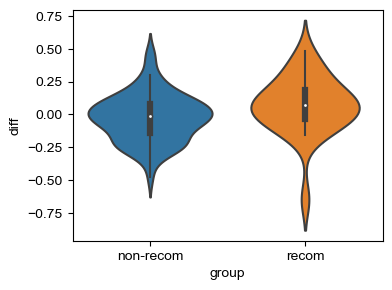

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(4,3))
sns.violinplot(x=df_val['group'], y=df_val['diff'])

plt.show()

In [85]:
for i in range(len(df_val)):
    if df_val['group'][i] == 'non-recom' and df_val['group'][i+1] == 'recom':
        cut = i+1

In [86]:
import numpy as np
import pandas as pd
from scipy import stats

stats.ks_2samp(df_val['diff'][:cut],df_val['diff'][cut:])

KstestResult(statistic=0.3076923076923077, pvalue=0.05175969430624888, statistic_location=0.0546324, statistic_sign=1)

/var/folders/b4/79t4ch4d6r75j7xb9y8qj3vc0000gn/T/ipykernel_11490/2608787600.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_val['diff'][:cut],label='non')
/var/folders/b4/79t4ch4d6r75j7xb9y8qj3vc0000gn/T/ipykernel_11490/2608787600.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_val

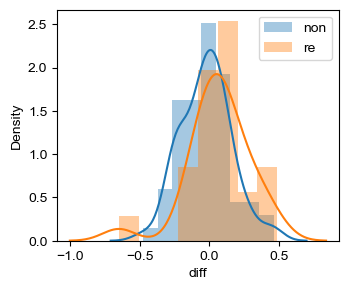

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8,3))

plt.subplot(121)
sns.distplot(df_val['diff'][:cut],label='non')
sns.distplot(df_val['diff'][cut:],label='re')
plt.legend()


plt.show()

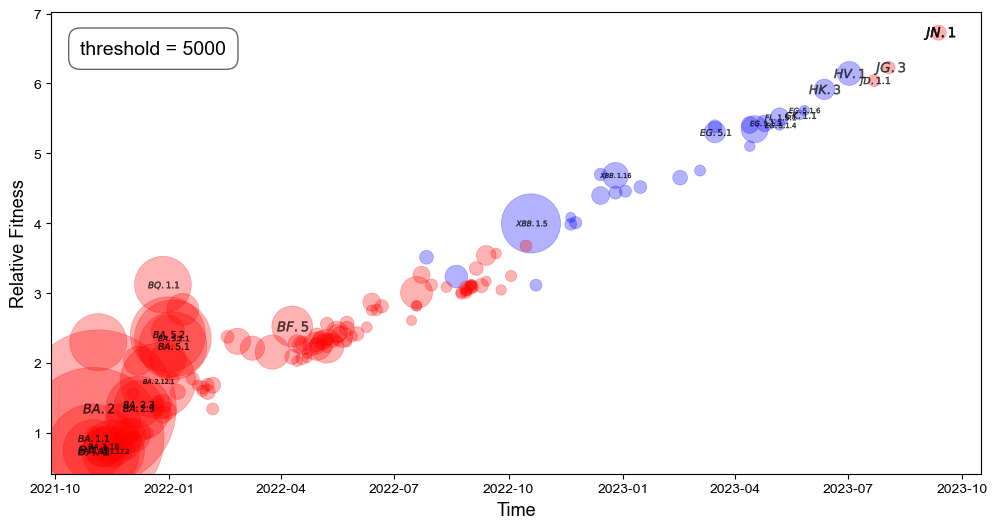

In [82]:
time = pd.to_datetime(lineage_fitness['start date'])
time1 = pd.to_datetime(label_lineage['start date'])

plt.figure(figsize=(12,6))
plt.rcParams['font.sans-serif'] = ['Arial']
plt.scatter(time, lineage_fitness['relative fitness'], s = size, c = color, alpha=0.3, lw=0.5)
for i in range(len(label_lineage_marker)):
    plt.scatter(time1[i], label_lineage['relative_fitness'][i], s = 500, c = 'black', marker = label_lineage_marker[i], alpha = 0.7, lw = 0.3)
plt.scatter(time1[0], label_lineage['relative_fitness'][0], s = 500, c = 'black', marker = label_lineage_marker[0], alpha = 0.7, lw = 0.3)

# plt.ylabel(('exp('+chr(916)+'$R/R_{A}$)'), fontsize=15)
plt.ylabel(('Relative Fitness'), fontsize=13)
plt.xlabel(('Time'), fontsize=13)
plt.text(0.11, 0.92, 'threshold = '+str(rou),
            fontsize = 14,
            horizontalalignment='center',
            verticalalignment='center', 
            transform=plt.gca().transAxes,
            bbox=dict(boxstyle='round,pad=0.6',facecolor='white',alpha=0.6)
               )